# CS 503 Foundation Models: Part 2 - nanoMaskGIT

#### Goals:

The goal of this second part is to familiarize yourself with the following topics:
- Bi-directional attention
- Encoder-only Transformer (e.g. BERT, MaskGIT, ...) models
- Basic masking schemes
- Masked modelling on text and images
- Masked inference

This notebook should give you a solid foundation of working with masked image models.
If you want to know more about these topics, please see some of the reading material in the lectures and at the bottom of this notebook, and feel free to ask the TAs.


#### Instructions:

- Your task is to fill in the missing code in the acompagning codebase (highlighted by `???`), run the training loops and evaluate the trained models with this notebook.
- Submit the notebook with all cells executed, as well as `nanofm/models/maskgit.py`.
- The notebooks are individual homework.

---

## 1 Setup

Please follow the setup detailed in the first notebook.

### 1.1 Imports

In [1]:
# Switch path to root of project
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
current_folder = globals()['_dh'][0]
os.chdir(os.path.dirname(os.path.abspath(current_folder)))

%load_ext autoreload
%autoreload 2

In [2]:
import re
import torch
from einops import rearrange
from transformers import AutoTokenizer
from tokenizers.processors import TemplateProcessing

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from nanofm.utils.checkpoint import load_model_from_safetensors
from nanofm.data.vision.tokenized_mnist import create_tokenized_mnist_dataloader, detokenize_MNIST

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# The flag below controls whether to allow TF32 on matmul. This flag defaults to False in PyTorch 1.12 and later.
torch.backends.cuda.matmul.allow_tf32 = True
# The flag below controls whether to allow TF32 on cuDNN. This flag defaults to True.
torch.backends.cudnn.allow_tf32 = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_grad_enabled(False)

---

## 2 Training nanoMaskGIT on MNIST for image generation

In this exercise, we will implement a simplified masked generative model, similar to [MaskGIT](https://masked-generative-image-transformer.github.io/). 
As with our nanoGPT implementation, we will train it on MNIST for image generation, but will also later explore using it for text generation on TinyStories!

#### Masked modeling - Training objective

In contrast to autoregressive models that are trained to predict the next token given the context so far, masked generative models like MaskGIT are trained to predict any (masked-out) token given any other (non-masked) subset of tokens.
Consider the following example: 

**Original Sentence:**  
```
"The quick brown fox jumps over the lazy dog."
```

**Masked Training Example (cloze):**  
```
"The quick [MASK] fox jumps over the [MASK] dog."
```

**Goal:**  
The model must predict:
- `[MASK]` → "brown"
- `[MASK]` → "lazy"

By repeatedly training the model to predict these randomly masked tokens across a large dataset, MaskGIT learns how tokens fit contextually within sequences.


#### Masked modeling - Inference


By training a model with randomized masking ratios, we are able to use it to progressively "unmask" a fully masked initial sequence.
At inference, the model starts with all tokens masked and progressively unmasks tokens in multiple steps. Let's show an inference example generating two (`k=2`) tokens at a time.

**Initial Masked Sequence:**  
```
"[MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK]"
```

**Step-by-step Generation (k=2 tokens at a time):**  

- **Step 1:**  
```
"The [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] dog."
```

- **Step 2:** (unmask next 2 most confident tokens)  
```
"The quick [MASK] [MASK] [MASK] [MASK] [MASK] lazy dog."
```

- **Step 3:** (unmask next 2 tokens)  
```
"The quick [MASK] fox [MASK] [MASK] [MASK] lazy dog."
```

- **Step 4:** (unmask next 2 tokens)  
```
"The quick brown fox jumps [MASK] the lazy dog."
```

- **Step 5 (Final):** (all tokens unmasked)  
```
"The quick brown fox jumps over the lazy dog."
```

At each inference step, MaskGIT predicts all masked-out tokens simultaneously (in parallel), and, based on the predicted probabilites, selects the `k` (here `k=2`) most likely tokens. 
After deciding on which tokens to use, we sample a token index from the predicted probability distribution for each token, and add the tokens to the sequence. 
This, now slightly less masked, sequence is then used as the input for the next round, where again, the `k=2` most confident tokens are chosen of the remaining masked targets.

A crucial difference of masked models to next-token prediction is that at each inference step we can freely choose the number of tokens `k` to simultaneously decode. 
Depending on the choice of `k`, this can speed up inference significantly, at little cost to generation performance. 
For example, see the comparison between raster-scan autoregressive, and masked generation below.
Each frame of the gif is one generation step. Autoregressive generation predicts each token one-by-one, while masked models may predict them in parallel.

![adsf](https://masked-generative-image-transformer.github.io/imgs/sampling.gif)

### 2.1 Overview and tasks

To implement nanoMaskGIT, we ask you to complete the subsections below by directly filling in the missing lines in the code base.

#### 2.1.1 Initialize nanoMaskGIT (5 points)

We will reuse the exact same Transformer layers and trunk built last week for the nanoGPT model, but this time we will use it to assemble a MaskGIT-like model in `nanofm.models.maskgit.MaskGIT`.
It consists of a few operations executed in series. Initialize the following modules in the constructor:
1. The discrete input tokens are embedded with an `nn.Embedding` layer. Initialize `self.input_embedding` accordingly, taking into account the vocabulary size.
2. On top of that, we add learnable positional embeddings. Initialize `self.positional_embedding` as an `nn.Parameter` containing a randomly initialized Tensor of shape (`max_seq_len`, `dim`).
3. To indicate masked-out tokens and provide placeholders to write the targets, initialize `self.mask_token` as an `nn.Parameter` containing a randomly initialized Tensor of shape (`dim`).
4. This then gets passed to a Transformer trunk. Initialize `self.trunk` with the trunk you implemented last week.
5. Finally we project the trunk output through a LayerNorm and output projection that maps the elements from the Transformer dimension to the vocabulary size (as a one-hot vector per token). Initialize `self.out_norm` and `self.to_logits`. The bias term for `self.to_logits` should always be set to False.

#### 2.1.2 Implement the forward function and loss (10 points)

Next, let's implement the `forward_model` function:
1. Pass the input tokens through the embedding. 
2. Given the `mask`, replace these embeddings by the learned `self.mask_token`, wherever `mask == True`.
3. Add the positional embedding, pass it through the Transformer trunk, output normalization, and output projection.
4. When calling the Transformer trunk, no attention mask needs to be specified. This model performs full self-attention between all masked and non-masked tokens.

Finally, we need to compute the cross-entropy loss between the logits and the ground-truth targets. Please complete the `compute_ce_loss` function accordingly, and take into account the ignore_index token. We do not want to compute a loss on non-masked tokens that we pass as input; we only compute it on masked-out tokens that we predict.

#### 2.1.3 Implement random masking (15 points)

As used in the `forward` function, during training we want to randomize the `mask` you just applied to the inputs. 
For that, please complete the `generate_random_mask` function that should return a random mask where True = masked-out and False = not masked.
Each sample in the batch should randomly mask out between 1 and L tokens, where L is the sequence length. 
When L tokens are masked-out, it means there is no input and all tokens are predicted.
When only 1 token is masked-out, it means that all but one token are given as input, and only one is predicted. 
You should be able to see why we have to have at least one token masked.

The returned mask tensor should be of type `torch.BoolTensor`, moved to the same device (GPU) as `seq`, and be of shape (B, L).
Note that both the number of mask tokens, as well as the placement of the masks should be sampled completely uniformly at random, for every sample in the batch individually.
That means you should not apply and broadcast the same mask to the entire batch.

#### 2.1.4 MaskGIT schedule and generation function (20 points)

Now let's implement the generation function. We do that in two steps:

First, let's implement a so-called generation schedule in `get_maskgit_schedule`. 
Its task is to give us a list of number of tokens to unmask at every prediction step. 
It's quite common to make this a cosine schedule, i.e. where the tokens are unmasked slowly at the beginning, then in the middle many tokens are predicted at once, and finally in the end we ramp down again.
Here we will implement a much simpler constant schedule, where the number of unmasked tokens per step is constant.
For example, if total_tokens = 17 and num_steps = 8, then the schedule should be: [2, 2, 2, 2, 2, 2, 2, 3]. 
If the total number of tokens is not divisible by the number of steps, we simply add the remainder to the last step.
The `schedule` should be a list of integers of length `num_steps`, where each integer represents the number of tokens to unmask at that step. 
The sum of the integers in `schedule` should equal `total_tokens`.

With the simple schedule implemented, let's use it in the `generate` function. Generation is performed in a loop in the following steps:
1. Given the sequence and mask so far, simply pass them through the network to get the logits.
2. Then, select the subset of logits that we actually want to predict, i.e. the masked-out tokens.
3. Over all these predicted tokens, we only want to keep the most "confident" predictions. We select for these by computing the maximum logit value for each token as a proxy. The higher the maximum logit is for a given token, the more "confident" it is in its prediction.
4. Now, let's select the top-k tokens according to these confidence scores. You get the number of tokens `k` from the generation schedule.
5. Sample the token indices from these `k` selected token logits. You should use the `sample_tokens` function from `utils/sampling.py`, and remember to pass the relevant sampling hyperparameters.
6. Update the sequence and mask for the next round using the newly sampled tokens and their positions.
7. Repeat until the end of the generation schedule, when the sequence is fully unmasked.

### 2.2 Training the model

We defined a training config for you in: `cfgs/nanoMaskGIT/mnist_d8w512.yaml`. Please familiarize yourself with all parts.
Please don't forget to replace the Weights & Bias entity with your own.

On a 1xV100 node, you can start the training like:
```
OMP_NUM_THREADS=1 torchrun --nproc_per_node=1 run_training.py --config cfgs/nanoMaskGIT/mnist_d8w512.yaml
```

This training should be pretty fast and only take a few minutes. Because masked image models are harder to overfit, we increased the number of training steps five-fold, compared to nanoGPT. You should reach a final validation loss below 0.57, and your loss curves should look something like the following:

<img src="./assets/nanoMaskGIT_mnist.png" alt="nanoMaskGIT MNIST loss curves" width="1000">

### 2.3 Show your loss curves (10 points)

Screenshot your loss curves and show them here. Add the image to the `assets` directory and change the path in the markdown. You will get 10 points for reasonable loss curves (similar to the sample loss curves above).

<img src="./assets/my_nanoMaskGIT_mnist.png" alt="nanoMaskGIT MNIST loss curves" width="1000">

### 2.4 Evaluating the model (10 points)

After you completed the training, load the model with the following cell. You may need to adjust the path if you changed it.
You will get 10 points if the outputs look reasonable (similar to the sample outputs provided below).

Hint: You can also load intermediate safetensors checkpoints to check the progress during training.

In [3]:
ckpt_path = './outputs/nanoMaskGIT/mnist_d8w512/checkpoint-final.safetensors'
model = load_model_from_safetensors(ckpt_path, device=device)
print(f'{model.get_num_params() / 10**6}M parameters')

25.174528M parameters


Let's plot some class-conditional generations! We seed the generation by providing the first token, whose index is equal to the number we'd like to generate.
For that token, we initialize the mask with `False`, i.e. indicating that that token is given as input, i.e. not masked. 
The rest of the tokens are masked, and it does not matter what value they have in the `seq` tensor, as they are overwritten by the learnable mask token in the Transformer.

In [4]:
label = 5

seq = torch.zeros(50, dtype=torch.long, device=device)
mask = torch.ones(50, dtype=torch.bool, device=device)
seq[0] = label
mask[0] = False

output = model.generate(seq, mask, num_steps=8, temp=1.0, top_p=0.9, return_history=False)
output

tensor([[ 5, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 25, 22, 10, 10, 10, 10, 11,
         24, 10, 10, 10, 10, 10, 14, 18, 12, 10, 10, 10, 10, 10, 10, 25, 10, 10,
         10, 10, 13, 13, 18, 10, 10, 10, 10, 10, 10, 10, 10, 10]],
       device='cuda:0')

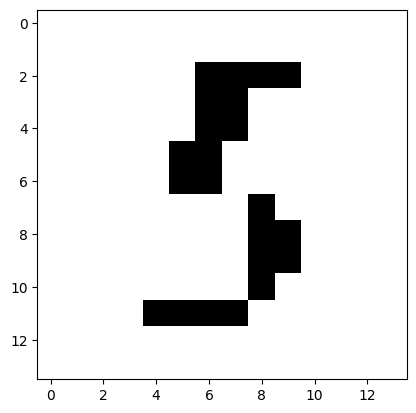

In [5]:
reconst = detokenize_MNIST(output, patch_size=2, account_for_labels=True).cpu()
plt.imshow(reconst[0], cmap='gray_r')

Let's now generate 10 random samples for all 10 classes. Most should look quite reasonable.

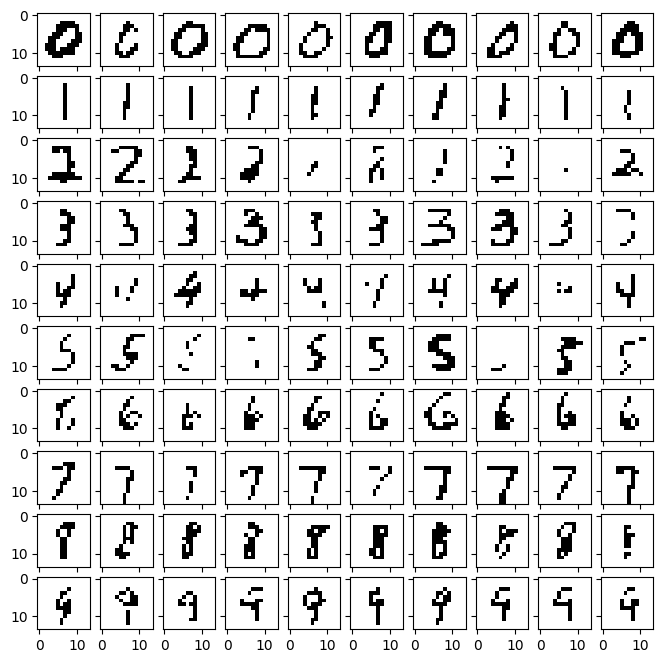

In [6]:
def generate_samples(model, num_steps=8, temp=1.0, top_p=0.0, top_k=0.0, n_samples=10):
    fig = plt.figure(figsize=(8., 8.))
    grid = ImageGrid(fig, 111, nrows_ncols=(10, n_samples), axes_pad=0.1)
    for label in range(10):
        for sample_idx in range(n_samples):
            grid_idx = label * n_samples + sample_idx
            
            seq = torch.zeros(50, dtype=torch.long, device=device)
            mask = torch.ones(50, dtype=torch.bool, device=device)
            seq[0] = label
            mask[0] = False
            output = model.generate(seq, mask, num_steps=num_steps, temp=temp, top_p=top_p, top_k=top_k, return_history=False)
            
            reconst = detokenize_MNIST(output, patch_size=2, account_for_labels=True).cpu()
            grid[grid_idx].imshow(reconst[0], cmap='Greys', vmin=0, vmax=1)
    plt.show()
    
generate_samples(model, num_steps=8, temp=0.7, top_p=0.9, top_k=0.0)

### 2.5 Open-ended questions (10 points each)

Please answer the following questions. You may use additional cells to demonstrate your answers if necessary.

#### 2.5.1 Intermediate generation steps

`model.generate` has an optional flag `return_history`. Show the intermediate generation steps. What do you observe?

In [7]:
# Fill your answer here
label = 5

seq = torch.zeros(50, dtype=torch.long, device=device)
mask = torch.ones(50, dtype=torch.bool, device=device)
seq[0] = label
mask[0] = False

seqs, masks = model.generate(seq, mask, num_steps=8, temp=1.0, top_p=0.9, return_history=True)

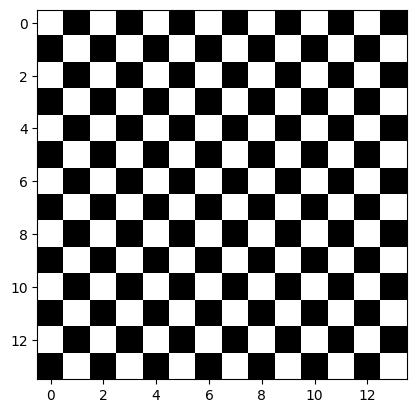

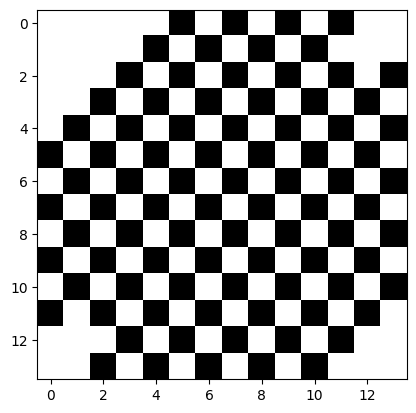

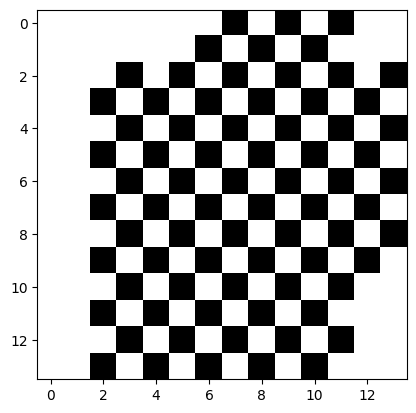

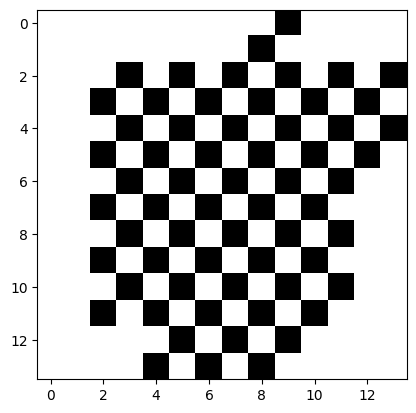

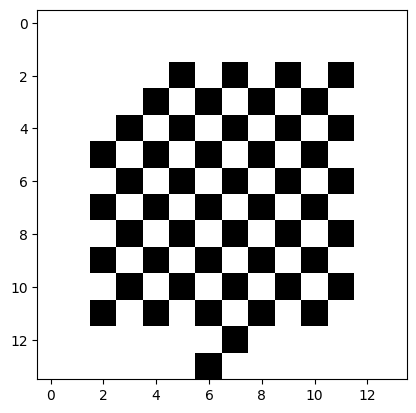

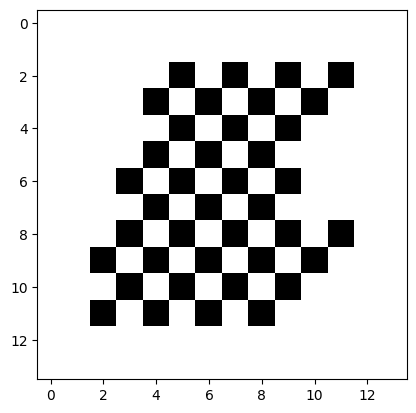

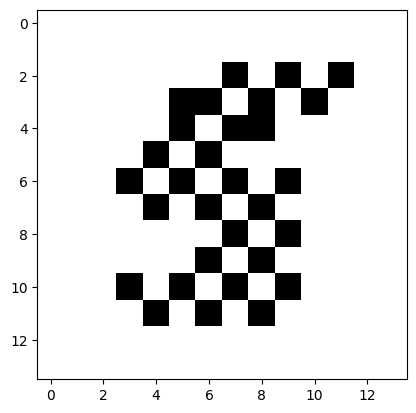

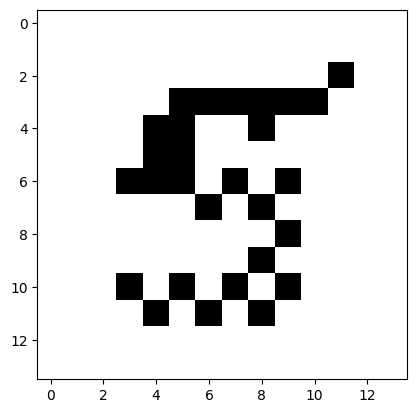

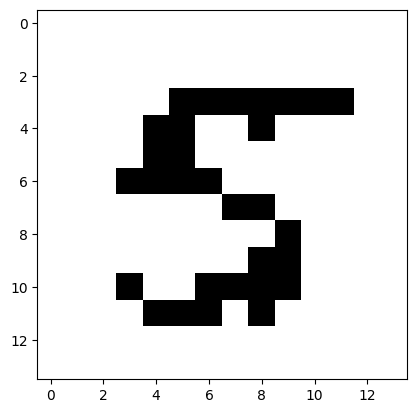

In [8]:
for out in seqs:
    reconst = detokenize_MNIST(out.unsqueeze(0), patch_size=2, account_for_labels=True).cpu()
    plt.imshow(reconst[0], cmap='gray_r')
    plt.show()

We observe how the image is generated. It starts from a regular pattern of a grid, and step by step change the pixel values. We observe that the pixel changes start from the boundaries with approximate changes, and progressively comes to the center of the image with more detailed and spotted modifications.

#### 2.5.2 Number of inference steps

With MaskGIT, we can freely choose the number of inference steps `k`. We default to `k=8`, but how does generation with `k` = 1, 4, 8, 16, 32, 49 perform? What do you observe?

========== k: 1 ==========


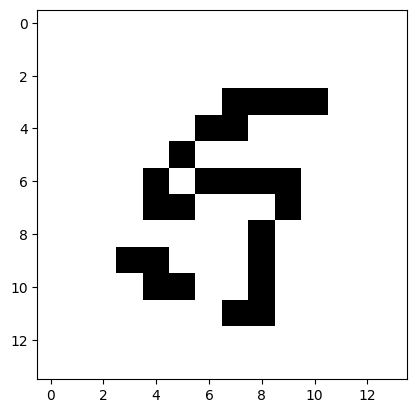

========== k: 4 ==========


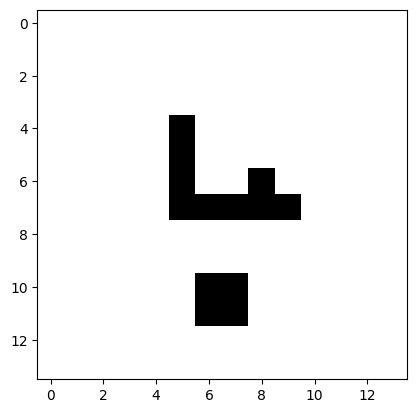

========== k: 8 ==========


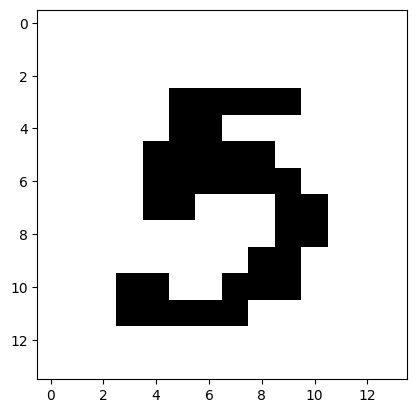

========== k: 16 ==========


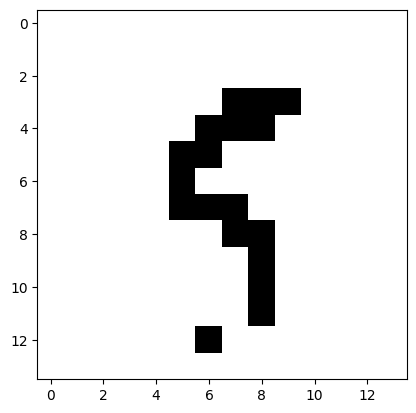

========== k: 32 ==========


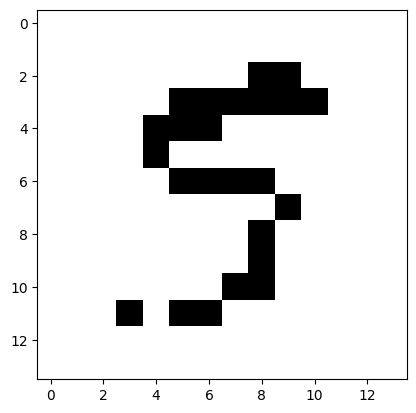

========== k: 49 ==========


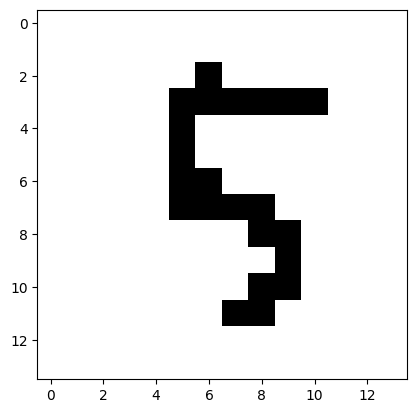

In [9]:
# Fill your answer here
label = 5
steps = [1,4,8,16,32,49]

for k in steps:
    print("="*10,"k:",k,"="*10)
    seq = torch.zeros(50, dtype=torch.long, device=device)
    mask = torch.ones(50, dtype=torch.bool, device=device)
    seq[0] = label
    mask[0] = False
    
    output = model.generate(seq, mask, num_steps=k, temp=1.0, top_p=0.9, return_history=False)

    reconst = detokenize_MNIST(output, patch_size=2, account_for_labels=True).cpu()
    plt.imshow(reconst[0], cmap='gray_r')
    plt.show()

The more we increase the number of steps, the more precise and detailed result we get. Too few steps gives a bad result since the model needs to infer all values at once. However, even with a high k value (like 32) we sometimes get strange results. With a k value of 8 or 16 the results are correct and recognizable, and with the highest k value 49 the results are generally fine enough.

---

## 3 Training nanoGPT on TinyStories

Masked generation is quite common for image generation, but has seen a recent resurgence for language models too (e.g. see [LLaDA](https://ml-gsai.github.io/LLaDA-demo/)). 
Let's run a little experiment and train a masked model on TinyStories, just as we did with nanoGPT.

### 3.1 Loading the tokenizer and helper functions

In [10]:
# Load the GPT-2 tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2", trust_remote_code=True)

# Add padding, start-of-sequence, and end-of-sequence tokens
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
tokenizer.add_special_tokens({
    'bos_token': '[SOS]',
    'eos_token': '[EOS]',
})
tokenizer._tokenizer.post_processor = TemplateProcessing(
    single="[SOS] $A [EOS]",
    special_tokens=[('[EOS]', tokenizer.eos_token_id), ('[SOS]', tokenizer.bos_token_id)],
)
tokenizer

GPT2TokenizerFast(name_or_path='gpt2', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[SOS]', 'eos_token': '[EOS]', 'unk_token': '<|endoftext|>', 'pad_token': '[PAD]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50257: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	50258: AddedToken("[SOS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	50259: AddedToken("[EOS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [11]:
def token_ids_to_text(token_ids, text_tokenizer):
    """ Helper function to turn token sequences back to well-formatted text. """
    decoded = text_tokenizer.decode(token_ids)
    # Remove [SOS], [EOS], and [PAD] tokens along with surrounding horizontal whitespace only.
    decoded = re.sub(r'[ \t]*\[(SOS|EOS|PAD)\][ \t]*', ' ', decoded)
    # Collapse extra horizontal spaces in each line without touching newline characters.
    decoded = '\n'.join([re.sub(r'[ \t]+', ' ', line).strip() for line in decoded.splitlines()])
    return decoded

### 3.2 Training the model

We defined a training config for you in: `cfgs/nanoMaskGIT/tinystories_d8w512.yaml`. Please familiarize yourself with all parts.
Please don't forget to replace the Weights & Bias entity with your own.

On a 2xV100 node, you can start the training like:
```
OMP_NUM_THREADS=1 torchrun --nproc_per_node=2 run_training.py --config cfgs/nanoMaskGIT/tinystories_d8w512.yaml
```

This training should take over one hour. You should reach a final validation loss around 2.05, and your loss curves should look something like the following:

<img src="./assets/nanoMaskGIT_tinystories.png" alt="nanoMaskGIT TinyStories loss curves" width="1000">

### 3.3 Show your loss curves (10 points)

Screenshot your loss curves and show them here. Add the image to the `assets` directory and change the path in the markdown. You will get 10 points for reasonable loss curves (similar to the sample loss curves above).

<img src="./assets/my_nanoMaskGIT_tinystories.png" alt="nanoMaskGIT TinyStories loss curves" width="1000">

### 3.4 Evaluating the model (10 points)

After you completed the training, load the model with the following cell. You may need to adjust the path if you changed it.
You will get 10 points if the outputs look reasonable (similar to the sample outputs provided below).

Hint: You can also load intermediate safetensors checkpoints to check the progress during training.

In [12]:
ckpt_path = './outputs/nanoMaskGIT/tinystories_d8w512/checkpoint-final.safetensors'
model = load_model_from_safetensors(ckpt_path, device=device)
print(f'{model.get_num_params() / 10**6}M parameters')

25.174528M parameters


Let's generate some random (unconditional) stories!

In [14]:
for _ in range(5):
    seq = torch.zeros(256, dtype=torch.long, device=device)
    mask = torch.ones(256, dtype=torch.bool, device=device)
    output = model.generate(seq, mask, num_steps=128, temp=1.0, top_k=100, return_history=False)
    print(token_ids_to_text(output[0], text_tokenizer=tokenizer))
    print('\n' + '-'*50 + '\n')

Once upon a time, was a little boy named Tim. He wanted to have a cookie. So he his mommy for, " she said not

But Tim did not want to order your things. Tim thought he could also have lots for the so he decided to go. to get market. his mommy said him what she wanted.

Then, Tim was very excited. He saw to try his own treats all over and he picked out more.

When he was done, the storemy gave the one away. Tim was so happy!

Mom said goodbye and opened his money next time he got another cookie. He was so proud of himself and he thanked his mom

--------------------------------------------------

T upon a time, there was a little girl called Emily. She was three years old. Every day, she would turn and turn the and come.

One day, Emily turned for a surprise in the garden. She saw a small circle in a garden. Emily was and watched. As had the turn go, carefully had a funny guess. The circle said it was Emily's all of fun.

The end .

--------------------------------------------------

O

### 3.5 Open-ended questions (10 points each)

Please answer the following questions. You may use additional cells to demonstrate your answers if necessary.

#### 3.5.1 Intermediate generation steps

Similar as in 2.5.1, `model.generate` has an optional flag `return_history`. Show the intermediate generation steps. What do you observe?

In [31]:
# Fill your answer here
label = 5

seq = torch.zeros(50, dtype=torch.long, device=device)
mask = torch.ones(50, dtype=torch.bool, device=device)

seqs, masks = model.generate(seq, mask, num_steps=8, temp=1.0, top_p=0.9, return_history=True)
for out in seqs:
    print('-'*50)
    print(token_ids_to_text(out, text_tokenizer=tokenizer))

--------------------------------------------------
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
--------------------------------------------------
!!!!! It. to! the ball do!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
--------------------------------------------------
The smart is!. It. to hold the ball do.!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
--------------------------------------------------
The smart is patient. It. to hold the ball do. The the the the!! the!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
--------------------------------------------------
The smart is patient. It. to hold the ball do. The the the the ball and the ball. The! run!!!!!!!!!!!!!!!!!!!!!!!!!
--------------------------------------------------
The smart is patient. It. to hold the ball do. The the the the ball and the ball. The ball run and the fence and on!!!!!!!!!!!!!!!!!!!!
--------------------------------------------------
The smart is patient. It. to hold the ball do. The the the the ball and the ball. The ball run and t

We observe how the sequence is generated step by step. We observe that the first steps are at random locations, then it is likely that the model generate groups of words close to the already generated words. Since our implementation sorts logits by confidence, one could support that the model is more confident to generate a masked word with context around than an isolated word.

#### 3.5.2 Number of inference steps

Similar as in 2.5.1, with MaskGIT, we can freely choose the number of inference steps `k`. We default to `k=8`, but how does generation with `k` = 1, 4, 8, 16, 32, 49 perform? What do you observe?

In [32]:
# Fill your answer here
label = 5
steps = [1,4,8,16,32,49]

for k in steps:
    print("="*10,"k:",k,"="*10)
    seq = torch.zeros(50, dtype=torch.long, device=device)
    mask = torch.ones(50, dtype=torch.bool, device=device)
    
    output = model.generate(seq, mask, num_steps=k, temp=1.0, top_p=0.9, return_history=False)
    
    print(token_ids_to_text(output[0], text_tokenizer=tokenizer))

========== k: 1 ==========
birds and and That, away the he He be Then living. had They her. and was." they farmerWow fun, star. horse if bigmy fun Ben the to the It pretty has so!" did her said was it the her cat
========== k: 4 ==========
girl, Tom Lily you of with little to wanted girl. show her that they always be with always colorily's.
was very helpful to on taught thought how the how the have drew were a She Lily,
they cr her for Sara kinds
========== k: 8 ==========
Its ow Our eyes are sitting One. One!" same the same of man on laughing The other boy down He like low, the
was, now this one one in that pointed run a yellow,. look! the a. the I smiled in
========== k: 16 ==========
at the computer were for things. His dog thing to do what the computer was He is happy. they stop to test and do a. They think the wants to be what is.

The computer things to strange a lab. They and big
========== k: 32 ==========
sawmy hugged anded and the little girl was still holding a hug. She took

The more we increase the number of steps, the more correct the syntax of the sentence is. With the lowest step value, we encounter a lot of syntactic error. With the highest step value, we notice much fewer syntactic error.

#### 3.5.3 Comparison to autoregressive generation

How would you compare these results to the ones you got from nanoGPT? What are some failure modes you observe? And what could be some benefits? Do you have any thoughs on how we can improve text generation with masked models, or should we just stick to autoregressive models?

With nanoGPT the sequences are more coherent with a logical progression than with nanoMaskGIT. The failures in nanoGPT involve strange repetitions, but are still understandable, while the failures in nanoMaskGIT makes nonsense generations. Overall we get better generations with nanoGPT. However, nanoMaskGIT benefits from its parallelization, and can be more creative. Masked models could be interesting to improve text generations in specific case like code parsing for example, where we know a specific fixed structure while we need to fill blanks inside, such as python functions.

## 4 Further reading

Here is some further reading material should you want to dive deeper on masked modeling.

Masked image generation:
- [MaskGIT: Masked Generative Image Transformer](https://arxiv.org/abs/2202.04200)
- [Muse: Text-To-Image Generation via Masked Generative Transformers](https://arxiv.org/abs/2301.00704)
- [MAGE: MAsked Generative Encoder to Unify Representation Learning and Image Synthesis](https://arxiv.org/abs/2211.09117)
- [Randomized Autoregressive Visual Generation](https://arxiv.org/abs/2411.00776)
- [RandAR: Decoder-only Autoregressive Visual Generation in Random Orders](https://arxiv.org/abs/2412.01827)
- [Autoregressive Image Generation without Vector Quantization](https://arxiv.org/abs/2406.11838)
- [4M: Massively Multimodal Masked Modeling](https://arxiv.org/abs/2312.06647)

Masked text generation:
- [Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer](https://arxiv.org/abs/1910.10683)
- [Structured Denoising Diffusion Models in Discrete State-Spaces](https://arxiv.org/abs/2107.03006)
- [Large Language Diffusion Models](https://arxiv.org/abs/2502.09992)

Masked pre-training:
- [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)
- [RoBERTa: A Robustly Optimized BERT Pretraining Approach](https://arxiv.org/abs/1907.11692)
- [ELECTRA: Pre-training Text Encoders as Discriminators Rather Than Generators](https://arxiv.org/abs/2003.10555)
- [Masked Autoencoders Are Scalable Vision Learners](https://arxiv.org/abs/2111.06377)
- [BEiT: BERT Pre-Training of Image Transformers](https://arxiv.org/abs/2106.08254)
- [BEiT v2: Masked Image Modeling with Vector-Quantized Visual Tokenizers](https://arxiv.org/abs/2208.06366)